In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [13]:
import matplotlib.pyplot as plt
import shutil
from tqdm.notebook import tqdm

import torch
from torch.utils.data import DataLoader

import torchvision.transforms as transforms
from utils import set_seed, ImageDataset, PhotoDataset, load_checkpoint, save_checkpoint

# Seed

In [3]:
device = 'mps' if torch.has_mps else 'cpu'
device

'mps'

In [4]:
set_seed(719)

# Dataset and Dataloader

In [5]:
img_ds = ImageDataset('./dataset/monet_jpg/', './dataset/photo_jpg/')

In [6]:
img_dl = DataLoader(img_ds, batch_size=1, pin_memory=True)

In [7]:
photo_img, monet_img = next(iter(img_dl))

In [8]:
def unnorm(img, mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]):
    for t, m, s in zip(img, mean, std):
        t.mul_(s).add_(s)
        
    return img

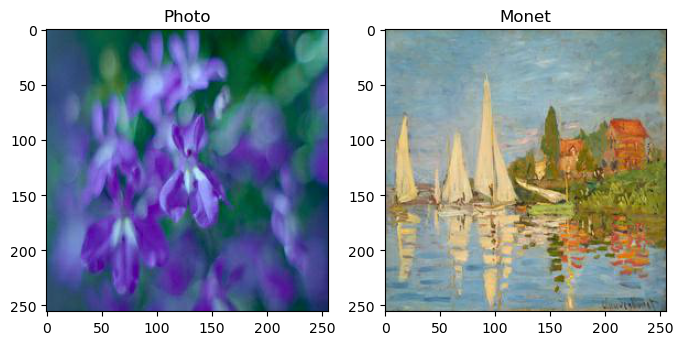

In [9]:
f = plt.figure(figsize=(8, 8))

f.add_subplot(1, 2, 1)
plt.title('Photo')
photo_img = unnorm(photo_img)
plt.imshow(photo_img[0].permute(1, 2, 0))

f.add_subplot(1, 2, 2)
plt.title('Monet')
monet_img = unnorm(monet_img)
plt.imshow(monet_img[0].permute(1, 2, 0))

# GAN Class

In [10]:
from  cycleGAN import CycleGAN
gan = CycleGAN(3, 3, 50, device)

In [16]:
# Save before train
save_dict = {
    'epoch': 0,
    'gen_mtp': gan.gen_mtp.state_dict(),
    'gen_ptm': gan.gen_ptm.state_dict(),
    'desc_m': gan.desc_m.state_dict(),
    'desc_p': gan.desc_p.state_dict(),
    'optimizer_gen': gan.adam_gen.state_dict(),
    'optimizer_desc': gan.adam_desc.state_dict()
}

In [13]:
gan.train(img_dl)

  0%|          | 0/300 [00:00<?, ?it/s]

/Users/zwill/miniforge3/envs/styleTransfer/lib/python3.10/site-packages/torch/autograd/__init__.py:197: UserWarning: The operator 'aten::sgn.out' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1675066389039/work/aten/src/ATen/mps/MPSFallback.mm:11.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


KeyboardInterrupt: 

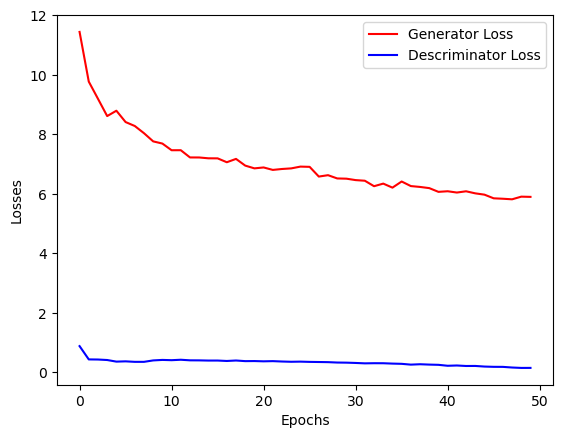

In [32]:
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.plot(gan.gen_stats.losses, 'r', label='Generator Loss')
plt.plot(gan.desc_stats.losses, 'b', label='Descriminator Loss')
plt.legend()
plt.show()

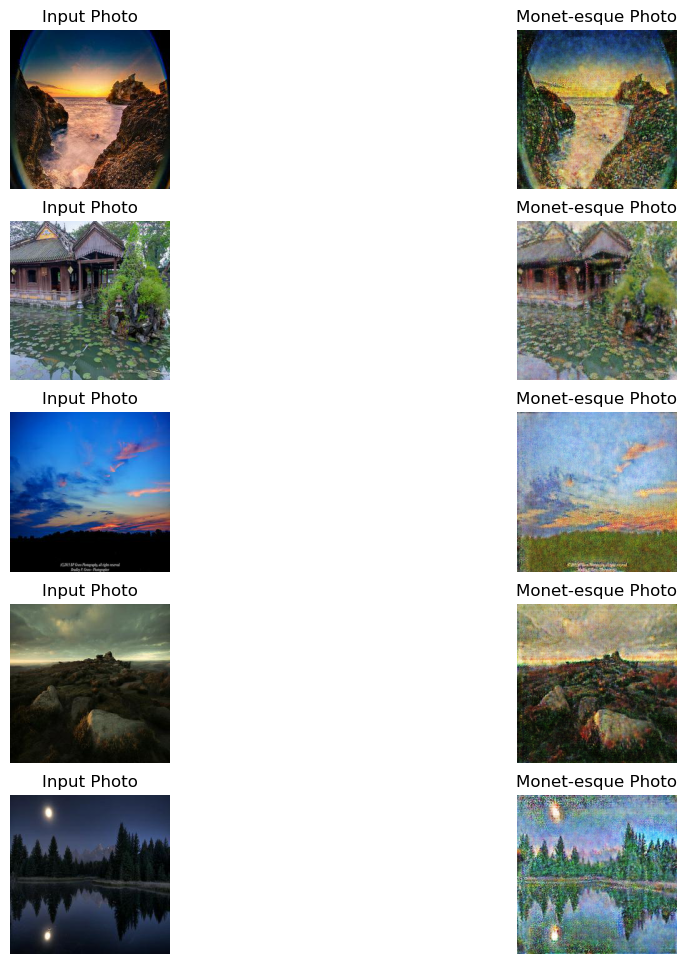

In [33]:
_, ax = plt.subplots(5, 2, figsize=(12, 12))
for i in range(5):
    photo_img, _ = next(iter(img_dl))
    pred_monet = gan.gen_ptm(photo_img.to(device)).cpu().detach()
    photo_img = unnorm(photo_img)
    pred_monet = unnorm(pred_monet)
    
    ax[i, 0].imshow(photo_img[0].permute(1, 2, 0))
    ax[i, 1].imshow(pred_monet[0].permute(1, 2, 0))
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque Photo")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

# Run Generator over all images

In [35]:
ph_ds = PhotoDataset('./dataset/photo_jpg/')

In [36]:
ph_dl = DataLoader(ph_ds, batch_size=1, pin_memory=True)

In [37]:
trans = transforms.ToPILImage()

In [38]:
t = tqdm(ph_dl, leave=False, total=ph_dl.__len__())
for i, photo in enumerate(t):
    with torch.no_grad():
        pred_monet = gan.gen_ptm(photo.to(device)).cpu().detach()
    pred_monet = unnorm(pred_monet)
    img = trans(pred_monet[0]).convert("RGB")
    img.save("./output/images/" + str(i+1) + ".jpg")

  0%|          | 0/7038 [00:00<?, ?it/s]

In [39]:
shutil.make_archive("./output/images", 'zip', "/ouput")

'/Users/zwill/PycharmProjects/styleTransfer/output/images.zip'